In [213]:
import pandas as pd
import pytrends
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [214]:
from pytrends.request import TrendReq

In [215]:
pytrends = TrendReq(hl='en-US', tz=360)

In [216]:
kw_list =["ESG"]
pytrends.build_payload(kw_list, geo ='GR')

In [217]:
df=pytrends.interest_over_time()

In [218]:
df.to_csv("greekGoogleTrendEsg.csv",sep=';')
df.head()
df['ESG'].dtype

dtype('int64')

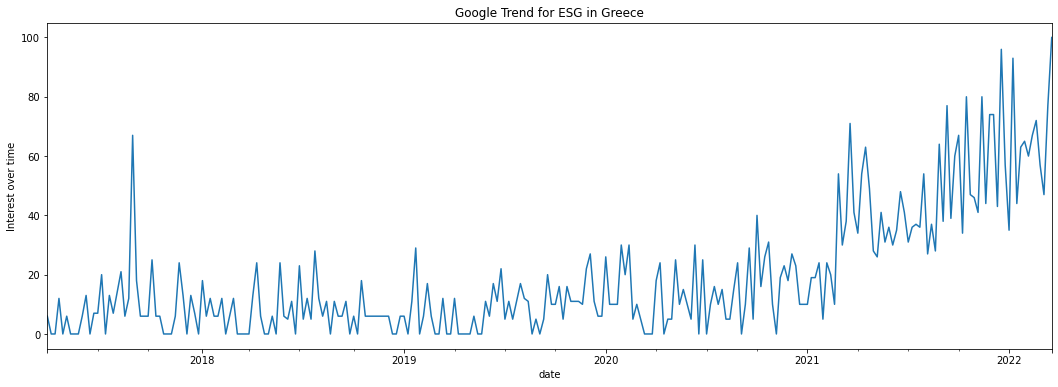

In [219]:
title='Google Trend for ESG in Greece'
ylabel='Interest over time'
ax=df['ESG'].plot(figsize=(18,6),title=title)
ax.set(ylabel=ylabel);

## ETS Decompositon model

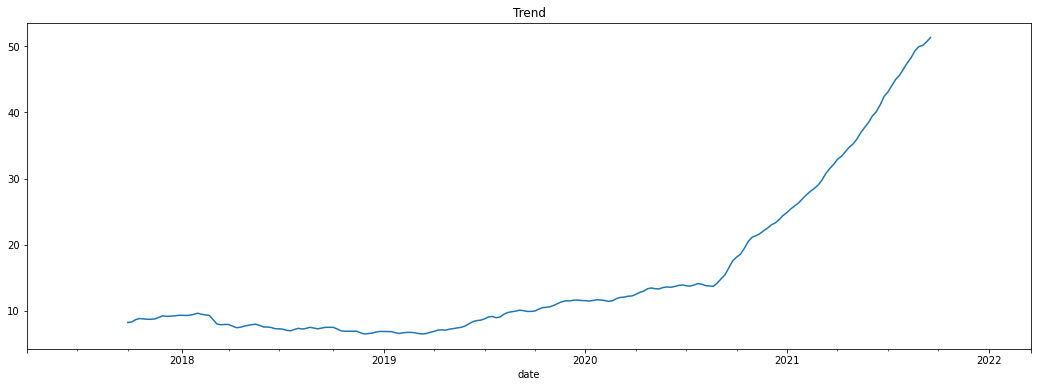

In [220]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize']=18,6


df.dropna(inplace=True)
result=seasonal_decompose(df['ESG'],model='additive')
result.trend.plot(title = "Trend");

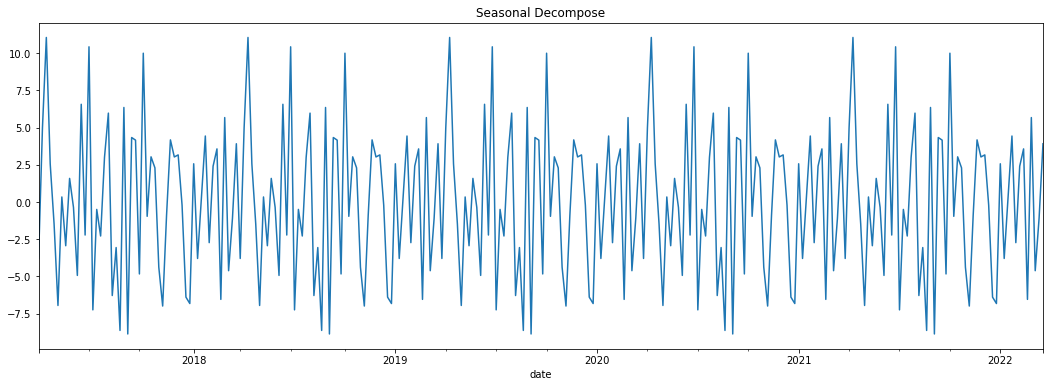

In [221]:
result.seasonal.plot(title="Seasonal Decompose", figsize=(18,6));

## 6-Month Simple Moving Average(SMA)

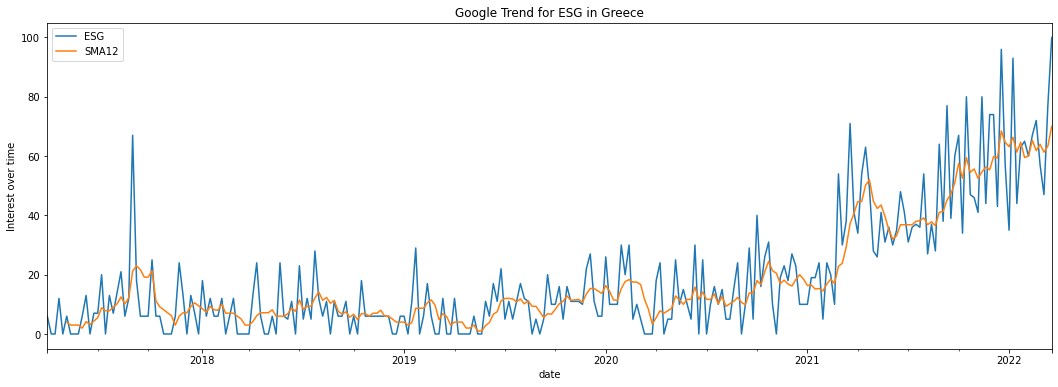

In [222]:
# 12months Simple Moving Average
df['SMA12']=df['ESG'].rolling(window=6).mean()
df[['ESG','SMA12']].plot(figsize=(18,6), title = title).set(ylabel = ylabel);

## Adding Exponentially Weighted Movining Average(EWMA) with 6 month span

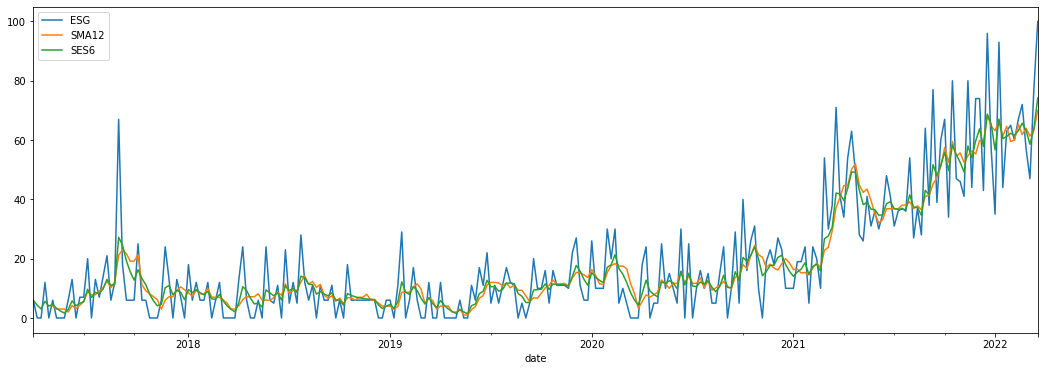

In [223]:
df['SES6']=df['ESG'].ewm(span=6,adjust=False).mean()
# df.head()
df[['ESG','SMA12','SES6']].plot();

## Adding Holt-Winters fitted model using Triple Exponential Smoothing with additive model

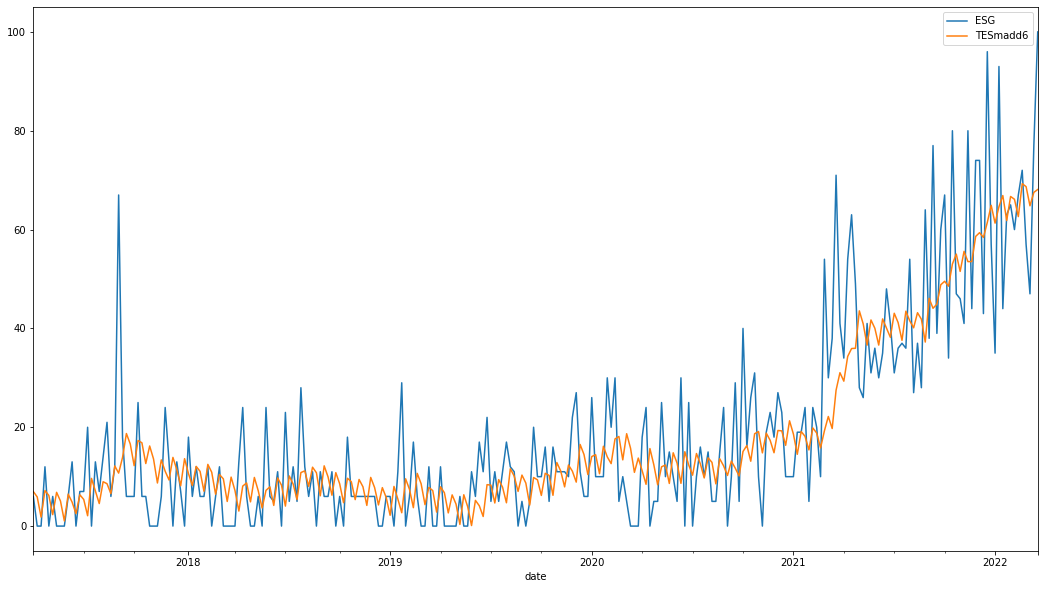

In [224]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df['TESmadd6']=ExponentialSmoothing(df['ESG'],trend='add',seasonal='add',seasonal_periods=6).fit().fittedvalues;
# df.head()
# df.columns
df[['ESG','TESmadd6']].plot(figsize=(18,10));

### ESG google search in Greece for the last 2 years

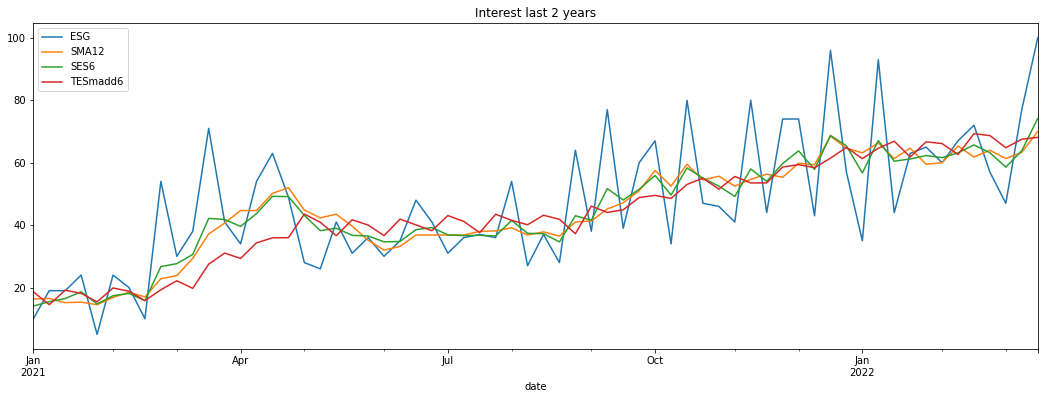

In [225]:
df[['ESG', 'SMA12', 'SES6', 'TESmadd6']]['2021-01-01':].plot(title='Interest last 2 years');

# Forcasting ESG google trend for Greece

## 1. Forecast with Holt-Winters model

In [226]:
# Split Data set to Train-Test set
df.info()
train_set = round(261*.8)
test_set = len(df)-train_set
train=df.iloc[:train_set]
test = df.iloc[train_set-5:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2017-04-02 to 2022-03-20
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ESG        260 non-null    int64  
 1   isPartial  260 non-null    bool   
 2   SMA12      255 non-null    float64
 3   SES6       260 non-null    float64
 4   TESmadd6   260 non-null    float64
dtypes: bool(1), float64(3), int64(1)
memory usage: 18.5 KB


In [227]:
train.tail()

,ESG,isPartial,SMA12,SES6,TESmadd6
date,,,,,
2021-02-28,54,False,22.833333,26.719859,19.297439
2021-03-07,30,False,23.833333,27.657042,22.179486
2021-03-14,38,False,29.333333,30.612173,19.744965
2021-03-21,71,False,37.166667,42.151552,27.495908
2021-03-28,41,False,40.666667,41.822537,31.042375


In [228]:
test.head()

,ESG,isPartial,SMA12,SES6,TESmadd6
date,,,,,
2021-02-28,54,False,22.833333,26.719859,19.297439
2021-03-07,30,False,23.833333,27.657042,22.179486
2021-03-14,38,False,29.333333,30.612173,19.744965
2021-03-21,71,False,37.166667,42.151552,27.495908
2021-03-28,41,False,40.666667,41.822537,31.042375


In [229]:
# Fit the model
fitted_model = ExponentialSmoothing(train['ESG'],trend='add',seasonal='add').fit()

In [230]:
# Forecast against test set
test_pred = fitted_model.forecast(90)
test_pred

2021-04-04    46.682673
2021-04-11    47.934357
2021-04-18    40.432066
2021-04-25    37.184561
2021-05-02    38.683773
                ...    
2022-11-20    61.339826
2022-11-27    60.337764
2022-12-04    60.584454
2022-12-11    57.329352
2022-12-18    51.329581
Freq: W-SUN, Length: 90, dtype: float64

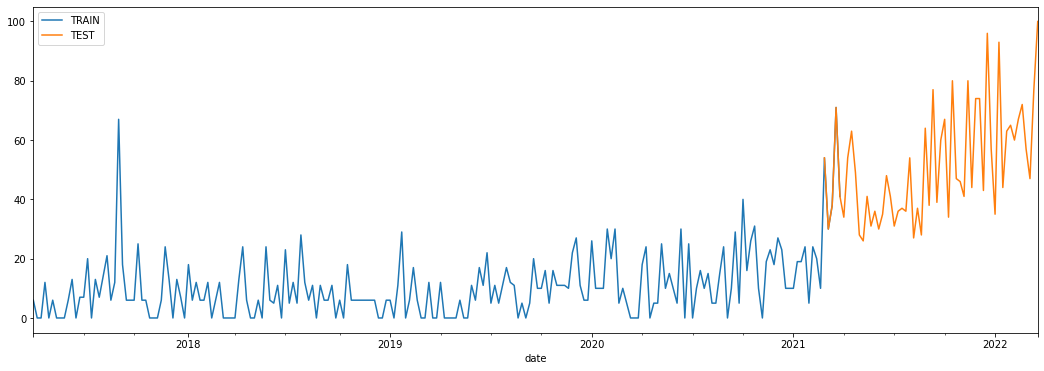

In [231]:
# plot train and test data
train['ESG'].plot(legend = True, label = 'TRAIN')
test['ESG'].plot(legend = True, label = 'TEST');

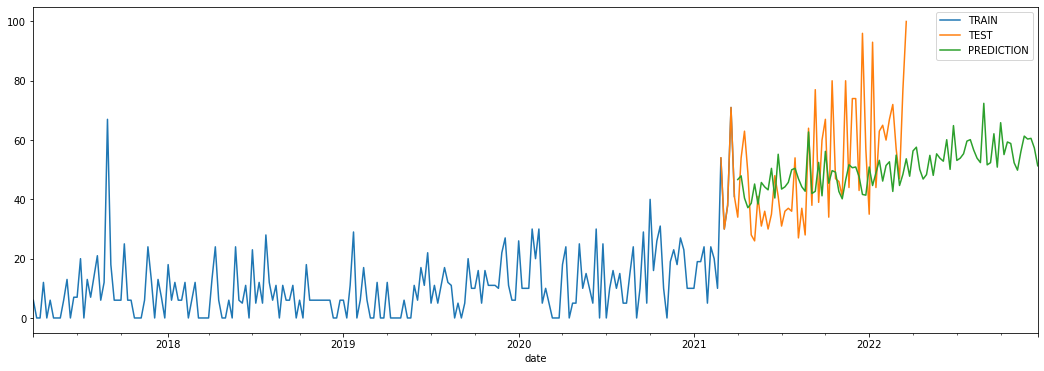

In [232]:
# Plot with prediction
train['ESG'].plot(legend = True, label = 'TRAIN')
test['ESG'].plot(legend = True, label = 'TEST')
test_pred.plot(legend = True, label='PREDICTION');

## 2. Exposing Seasonality on Monthly base-plot

<AxesSubplot:xlabel='date'>

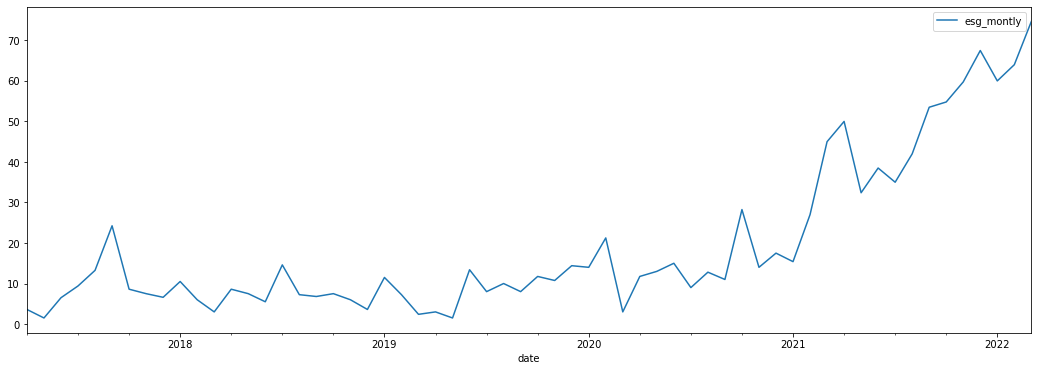

In [233]:
from statsmodels.graphics.tsaplots import month_plot
dfMonthly = df['ESG'].resample(rule='M').mean().rename('esg_montly')
dfMonthly.plot(legend = 'True')

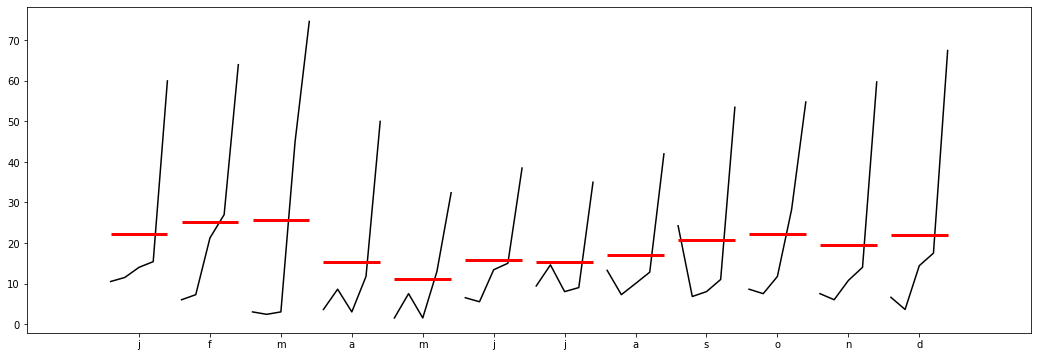

In [234]:
month_plot(dfMonthly);

## 3. Test for Stationarity

In [235]:
from statsmodels.tsa.stattools import adfuller

In [294]:
adfuller(dfMonthly)

(2.941001779342368,
 1.0,
 7,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 318.7060248680268)

p-value  = 1.0 therefore data is nonstationary(0.05< for stationary), needs Differencing for ARIMA model

## 4. Run acf and pacf plots

In [237]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

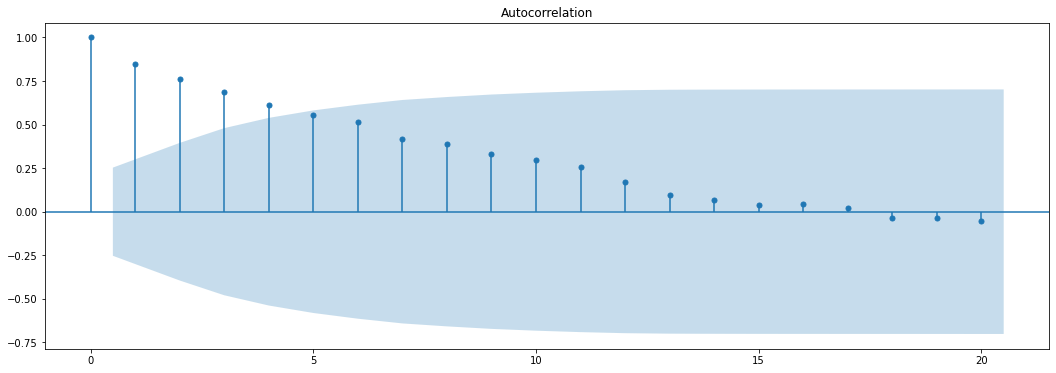

In [238]:
plot_acf(dfMonthly, lags=20);

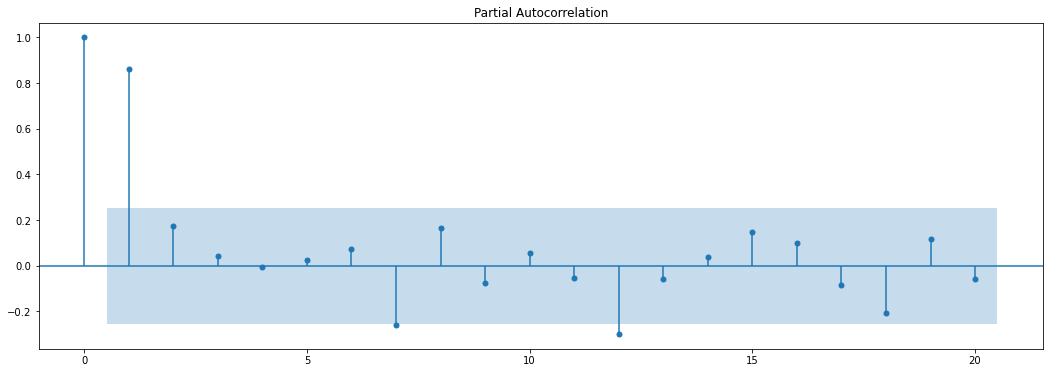

In [239]:
plot_pacf(dfMonthly, lags=20);

## Run SARIMA model

In [278]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

In [279]:
auto_arima(dfMonthly, seasonal=False,stepwise=True,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=405.272, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=407.237, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=403.630, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=401.982, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=406.789, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=403.607, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=403.651, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=405.607, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=403.752, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.919 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -197.991
Date:                Sun, 27 Mar 2022   AIC                            401.982
Time:                        23:29:46   BIC                            408.214
Sample:                             0   HQIC                           404.415
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1447      0.656      1.746      0.081      -0.141       2.430
ma.L1         -0.4051      0.105     -3.846      0.000      -0.612      -0.199
sigma2        47.9729      8.263      5.806      0.000      31.778      64.168
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 2.52
Prob(Q):                              0.81   Prob(JB):                         0.28
Heteroskedasticity (H):               2.63   Skew:                             0.42
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [280]:
# split data
len(dfMonthly)
train =dfMonthly.iloc[:48]
test = dfMonthly.iloc[48:]

In [281]:
# Fit ARIMA(ARIMA(0,1,1)(0,0,0,12))
model = ARIMA(train,order=(0,1,1))
result = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28990D+00    |proj g|=  4.60711D-03

At iterate    5    f=  3.28976D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   0.000D+00   3.290D+00
  F =   3.2897569170951728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [282]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.esg_montly   No. Observations:                   47
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -154.619
Method:                       css-mle   S.D. of innovations              6.462
Date:                Sun, 27 Mar 2022   AIC                            315.237
Time:                        23:29:56   BIC                            320.788
Sample:                    05-31-2017   HQIC                           317.326
                         - 03-31-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5616      0.405      1.386      0.166      -0.233       1.356
ma.L1.D.esg_montly    -0.6084      0.175     -3.477      0.001      -0.951      -0.265
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.6436           +0.0000j            1.6436            0.0000
-----------------------------------------------------------------------------
"""

In [283]:
# Predict
start = len(train)
end = len(train)+len(test)-1

In [284]:
predictions = result.predict(start=start,end=end,typ='levels').rename('ARIMA Prediction')

In [285]:
predictions

2021-04-30    31.526429
2021-05-31    32.088071
2021-06-30    32.649713
2021-07-31    33.211356
2021-08-31    33.772998
2021-09-30    34.334640
2021-10-31    34.896282
2021-11-30    35.457925
2021-12-31    36.019567
2022-01-31    36.581209
2022-02-28    37.142852
2022-03-31    37.704494
Freq: M, Name: ARIMA Prediction, dtype: float64

<AxesSubplot:xlabel='date'>

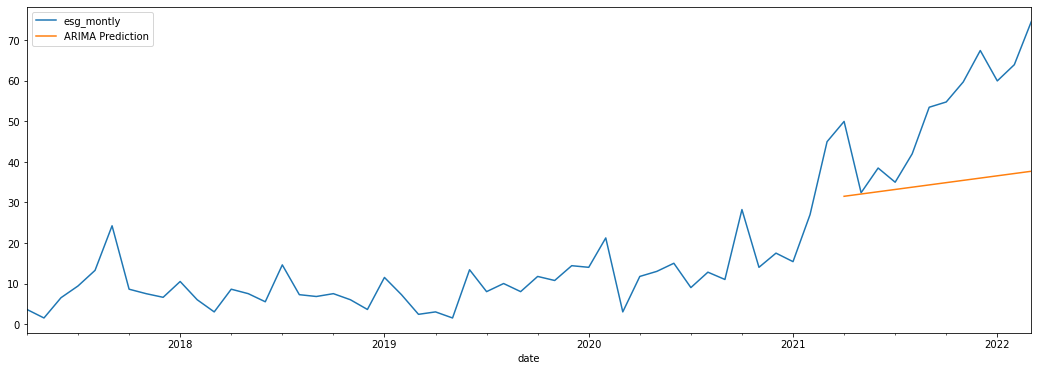

In [286]:
dfMonthly.plot(legend=True)
predictions.plot(legend=True)

In [287]:
# Evaluation
from statsmodels.tools.eval_measures import rmse
error = rmse(test,predictions)
print(f'RMSE error: {error:.5}')

RMSE error: 21.266


In [288]:
test.mean()

52.67638888888889

In [289]:
# Retrain the model on the full data, and forecast 12 months

In [292]:
model = ARIMA(dfMonthly,order=(0,1,1))
results=model.fit()
len(dfMonthly)
fcast=results.predict(start=len(dfMonthly),end=len(dfMonthly)+12,typ='levels').rename('ARIMA ESG FORECAST 12months')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35582D+00    |proj g|=  3.62834D-03

At iterate    5    f=  3.35578D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   8.882D-08   3.356D+00
  F =   3.3557780318807771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


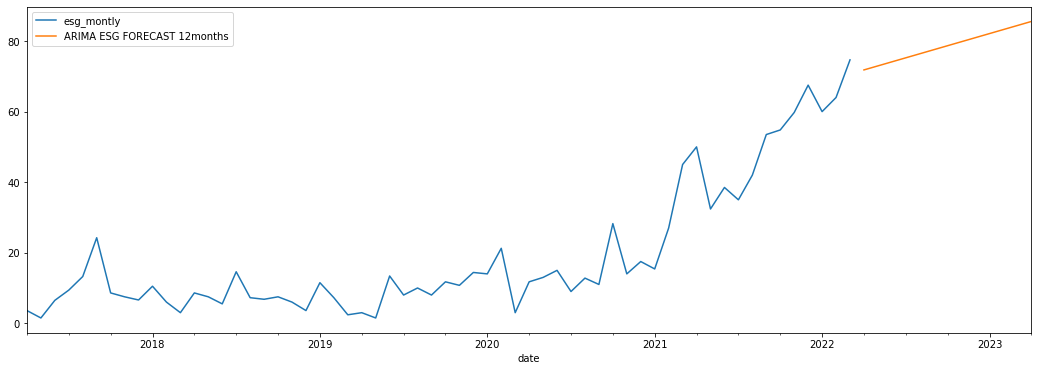

In [293]:
dfMonthly.plot(legend=True)
fcast.plot(legend=True);